In [3]:
# 02_main.ipynb
from grav_lens import get_datasets

from utils.model import create_model
from utils.loadsave import load_model_with_hyperparameters, load_hyperparameters, save_hyperparameters
from utils.optimize import dimensions, default_parameters

import time
import pickle

from tensorflow.keras import backend as K

import tensorflow.keras.activations as activations
import os 

# se permite el uso de rutas absolutas ahora
home_data = r"C:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\data"

get_datasets(data_index='1', max_files=32*4, 
    home=home_data)


Using data folder: C:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\data\1


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>)

In [5]:

# Ejemplo de uso
# INDEX 0 es una carpeta de datasets mucho mas chica
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=32*4, 
    home=home_data)

for X, Y in train_dataset.take(1):  # Mostrar un batch de entrenamiento
    print("Train X:", X.shape)
    print("Train Y:", Y.shape)

for X, Y in val_dataset.take(1):  # Mostrar un batch de validación
    print("Val X:", X.shape)
    print("Val Y:", Y.shape)

for X, Y in test_dataset.take(1):  # Mostrar un batch de prueba
    print("Test X:", X.shape)
    print("Test Y:", Y.shape)


Using data folder: ..\..\data\1
Train X: (32, 128, 128, 3)
Train Y: (32, 128, 128, 1)
Val X: (25, 128, 128, 3)
Val Y: (25, 128, 128, 1)
Test X: (12, 128, 128, 3)
Test Y: (12, 128, 128, 1)


In [7]:
train_dataset.map(lambda x: x)

TypeError: in user code:


    TypeError: <lambda>() takes 1 positional argument but 2 were given


In [3]:
# # Función de mapeo para las salidas
# def map_to_multiple_outputs(X, y, output_names):
#     outputs = {name: y for name in output_names}  # Mapea y_true a todos los nombres de salida
#     return X, outputs

# # Aplicar la función de mapeo al dataset
# output_names = ['output_image', 'output_mae', 'output_mse', 'output_dice']

# train_dataset = train_dataset.map(lambda X, y: map_to_multiple_outputs(X, y, output_names))
# val_dataset = val_dataset.map(lambda X, y: map_to_multiple_outputs(X, y, output_names))
# test_dataset = test_dataset.map(lambda X, y: map_to_multiple_outputs(X, y, output_names))

# Arquitectura para lab
Aqui es posible tener acceso a lo que seria el `model.py`, sin necesaidad de resetear todo el tiempo

In [80]:
import tensorflow as tf

# caxar si la metrica DICEE es diferenciable
@tf.function
def dice_loss_bin(y_true, y_pred):
    mean_true = tf.reduce_mean(y_true)
    mean_pred = tf.reduce_mean(y_pred)
 
    y_true_bin = activations.sigmoid(y_true - mean_true)
    y_pred_bin = activations.sigmoid(y_pred - mean_pred)
 
    intersection = tf.reduce_sum(y_true_bin * y_pred_bin)
    dice_coefficient = (2. * intersection + 1e-7) / (tf.reduce_sum(y_true_bin) + tf.reduce_sum(y_pred_bin) + 1e-7)
 
    return 1 - dice_coefficient

@tf.function
def ssim_loss(y_true, y_pred):
    # Ajustar el rango dinámico según la escala de tus imágenes [-1, 1] 
    max_val = 2.0  # Porque las imágenes están en el rango [-1, 1]
    ssim_index = tf.image.ssim(y_true, y_pred, max_val=max_val)
    return 1 - tf.reduce_mean(ssim_index)  # Minimiza 1 - SSIM para maximizar SSIM



mape_callable = tf.keras.losses.MeanAbsolutePercentageError(
    reduction='sum_over_batch_size',
    name='mean_absolute_percentage_error'
)


# def combined_loss(weight_kl=0.1, weight_dice = 32768, weight_mape = 1):
#     #  32768 es igual al MAE maximo asumiendo ranogs (-1,1) con 128x128 pixeles
#     def loss(y_true, y_pred):
#         mae_loss = tf.keras.losses.mae(y_true, y_pred)
#         # kl_loss = tf.keras.losses.kld(y_true, y_pred) # requeire modificacion
#         dice_loss = dice_loss_bin(y_true, y_pred)
#         mape_loss = mape_callable(y_true, y_pred)
#         return mae_loss + weight_kl * kl_loss + weight_dice * dice_loss + weight_mape * mape_loss
#     return loss

class IdentityLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return inputs



In [81]:
# TOOD Agregar regularizacion de dropout

def create_model(learning_rate=1e-4, 
                 h_kernel_size=3, 
                 hidden_filters=64,
                 out_kernel_size=3,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-7,
                 decay_steps=100,
                 decay_rate=0.96):
    """
    Modelo que agranda las dimensiones espaciales hasta 256x256 y luego las reduce a 128x128.
    """
    initializer = tf.keras.initializers.GlorotNormal()
    input_layer = tf.keras.layers.Input(shape=(128, 128, 3))
    x = tf.keras.layers.Conv2D(16, (3, 3), activation="sigmoid", padding='same', kernel_initializer=initializer)(input_layer)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="softplus", padding='same', kernel_initializer=initializer)(input_layer)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(hidden_filters, (h_kernel_size, h_kernel_size), kernel_initializer=initializer, activation="softplus", padding='same')(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="softplus", padding='same', kernel_initializer=initializer)(x)
    output_image = tf.keras.layers.Conv2D(1, (out_kernel_size, out_kernel_size), activation="tanh", padding='same', name='output_image', kernel_initializer=initializer)(x)


    # Salidas adicionales para las pérdidas, usando la capa de identidad personalizada
    # output_mae = tf.keras.layers.Lambda(lambda x: x, name='output_mae')(output_image)
    # output_mae = IdentityLayer(name='output_mae')(output_image)
    # output_mse = IdentityLayer(name='output_mse')(output_image)
    # #output_kld = IdentityLayer(name='output_kld')(output_image)
    # output_dice = IdentityLayer(name='output_dice')(output_image)

    model = tf.keras.models.Model(inputs=input_layer, 
        #outputs=[output_image, output_mae])
        outputs=[output_image, output_image, output_image] )#, output_mse,
        # output_kld, 
        #output_dice])



    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=decay_steps,
      decay_rate=decay_rate,
      staircase=True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, 
                                         beta_1=beta_1, 
                                         beta_2=beta_2, 
                                         epsilon=epsilon)

    # Compile con múltiples funciones de pérdida
    model.compile(optimizer=optimizer, 
                loss= [ssim_loss,'mse', 'mae'], # MAE
                        # 'output_mae': 'mae',  # MAE
                        # 'output_mse': 'mse', 
                        # #'output_kld': 'kld', 
                        # 'output_dice': dice_loss_bin},
                metrics={'output_image': ['mae', 'mse', ssim_loss]})
                        #    'output_mae': ['mae'], 
                        #    'output_mse': ['mse'], 
                        #    'output_dice': [dice_loss_bin]})
    return model

#folder = 'results_2_dani'
#hyperparameter = load_hyperparameters(2, folder)
model = create_model()

#history = model.fit(train_dataset, epochs=10, verbose=True)

In [75]:
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Conv2D)           │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,897 (222.25 KB)

 Trainable params: 56,897 (222.25 KB)

 Non-trainable params: 0 (0.00 B)

Graficando como se ven las distintas funciones de perdiada

In [82]:
history = model.fit(train_dataset, epochs=5, verbose=True)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - loss: 0.9851 - output_image_mae: 0.1946 - output_image_mse: 0.0478 - output_image_ssim_loss: 0.9247
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 1.0130 - output_image_mae: 0.4084 - output_image_mse: 0.1768 - output_image_ssim_loss: 0.9497
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 1.0099 - output_image_mae: 0.6625 - output_image_mse: 0.4434 - output_image_ssim_loss: 0.9468
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - loss: 1.0112 - output_image_mae: 0.7880 - output_image_mse: 0.6240 - output_image_ssim_loss: 0.9480
Epoch 5/5


KeyboardInterrupt: 

In [69]:
history.history

{'loss': [0.9906136393547058,
  0.9860544800758362,
  0.8851839900016785,
  1.015311598777771,
  1.0149182081222534],
 'output_image_mae': [0.8685921430587769,
  0.6162713170051575,
  0.19972655177116394,
  0.20613375306129456,
  0.4264364540576935],
 'output_image_mse': [0.7599485516548157,
  0.3931347727775574,
  0.05944554880261421,
  0.05064086988568306,
  0.18826737999916077],
 'output_image_ssim_loss': [0.7428617477416992,
  0.7393636703491211,
  0.6564935445785522,
  0.7613626718521118,
  0.761164665222168]}

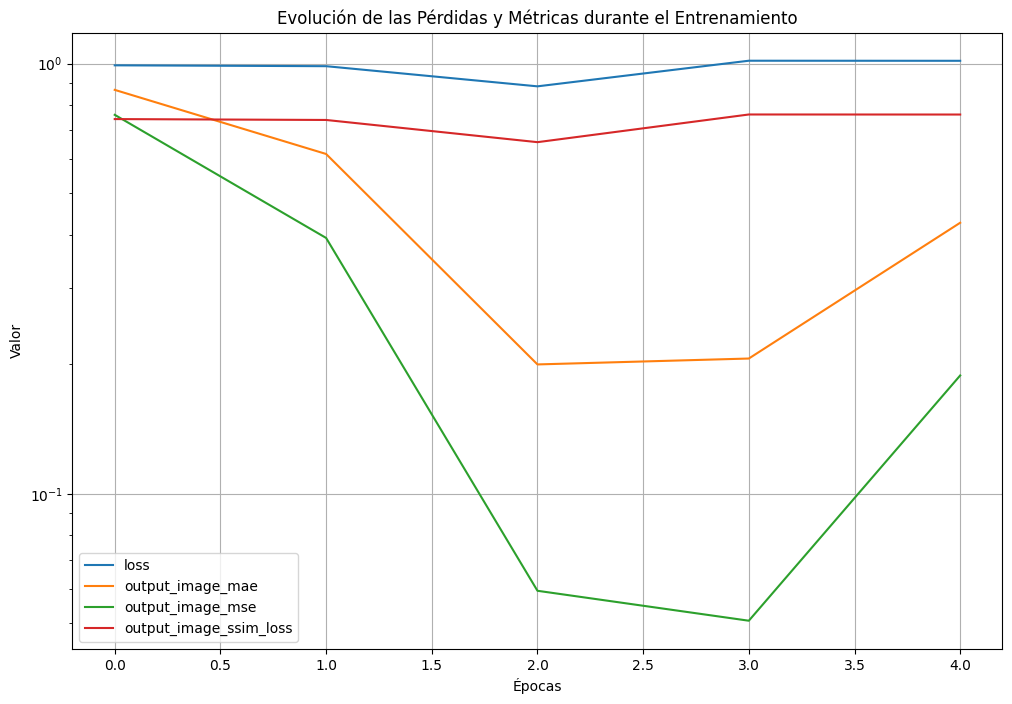

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Crear una figura
plt.figure(figsize=(12, 8))

# Graficar cada métrica en history.history
for key in history.history.keys():
    plt.plot(history.history[key], label=key)

plt.yscale('log')
# Configurar los detalles de la gráfica
plt.title('Evolución de las Pérdidas y Métricas durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
history = model.fit(train_dataset, epochs=10, verbose=True)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 0.2293 - output_image_dice_loss_bin: 0.4687 - output_image_mae: 0.2293 - output_image_mse: 0.0792
Epoch 2/10


C:\Users\fbien.DESKTOP-6FMEAR7\Documents\python\lib\contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 0.2210 - output_image_dice_loss_bin: 0.4688 - output_image_mae: 0.2210 - output_image_mse: 0.0738
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step - loss: 0.2134 - output_image_dice_loss_bin: 0.4688 - output_image_mae: 0.2134 - output_image_mse: 0.0691
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.2068 - output_image_dice_loss_bin: 0.4687 - output_image_mae: 0.2068 - output_image_mse: 0.0651
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step - loss: 0.2009 - output_image_dice_loss_bin: 0.4688 - output_image_mae: 0.2009 - output_image_mse: 0.0615
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - loss: 0.1951 - output_image_dice_loss_bin: 0.4688 - output_image_mae: 0.1951 - output_image_mse: 0.0582
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - loss: 0.1899 - output_image_dice_loss_bin: 0.4687 - output_image_mae: 0.1899 - output_image_mse: 0.0553
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - loss: 0.1848 - output_image_dice_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
(3, 128, 128, 1)


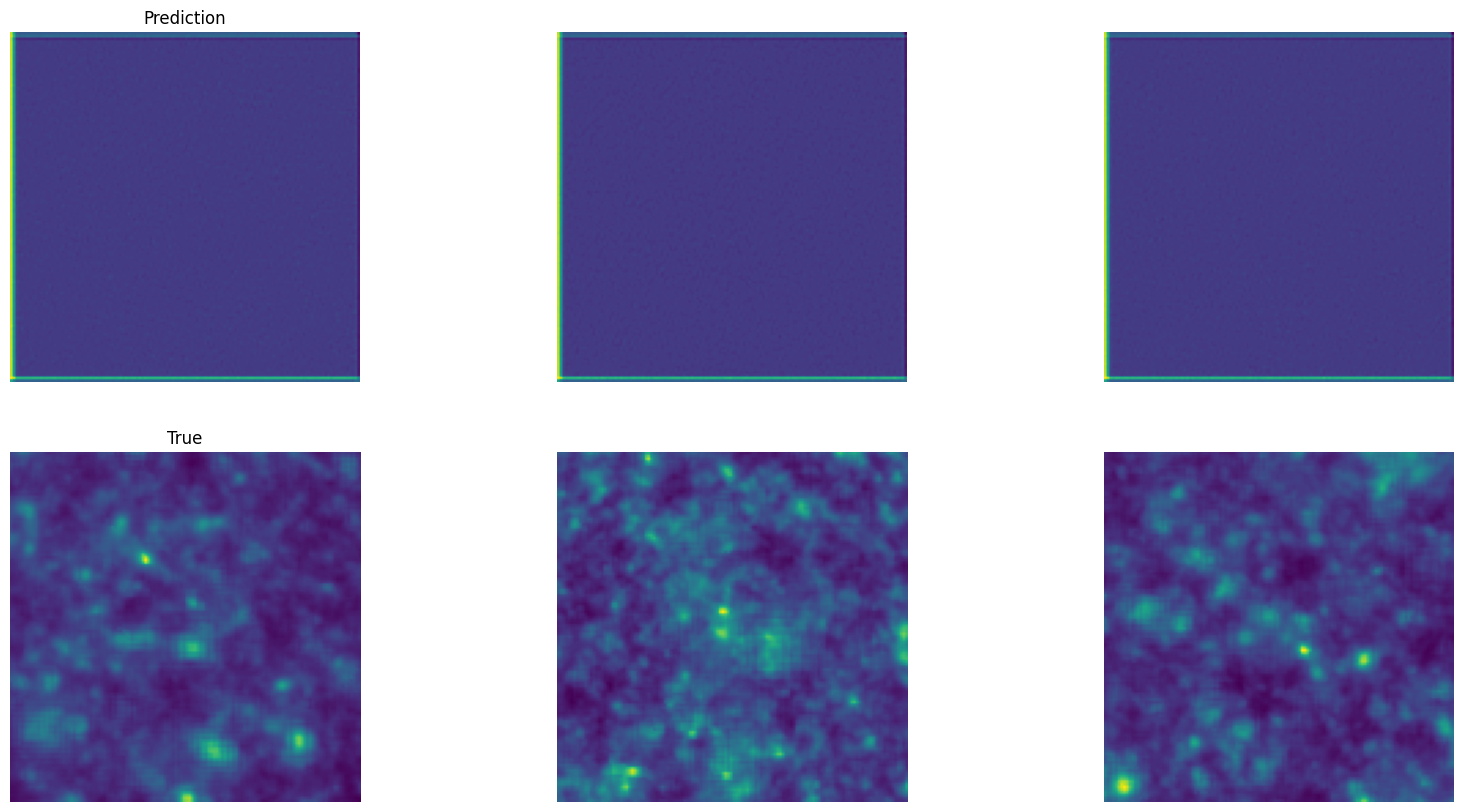

In [71]:

for X, Y in test_dataset.take(1):
    prediction = model.predict(X)[0]


# Obtener la primera imagen de la predicción
start = 3
end = start + 3
predicted_images = prediction[start:end]
true_images = Y[start:end]
print(predicted_images.shape)

# Configurar la figura
fig, axes = plt.subplots(2, predicted_images.shape[0], figsize=(20, 10))
axes = axes.flatten()

# Graficar cada imagen predicha
for i, (img_pred, img_true) in enumerate(zip(predicted_images, true_images)):
    axes[i].imshow(img_pred)  # Mostrar imagen predicha
    axes[i].axis('off')
    if i == 0:
        axes[i].set_title("Prediction")
    
    axes[i + predicted_images.shape[0]].imshow(img_true)  # Mostrar imagen verdadera
    axes[i + predicted_images.shape[0]].axis('off')
    if i == 0:
        axes[i + predicted_images.shape[0]].set_title("True")

plt.show()